In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import os
from sklearn.metrics import f1_score
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime
from xgboost import XGBClassifier

In [16]:
# Путь к директории с данными

data_dir = '../00_data/track_1/'
sumbit_dir = '../02_submits/'
preprocessed_dir = '../03_preprocessed_data/'

os.listdir(data_dir)

['.~lock.train.csv#',
 'hydro_1day.csv',
 'hydro_coord.csv',
 'ice_saw.csv',
 'meteo_1day.csv',
 'meteo_1month.csv',
 'meteo_3hours.csv',
 'meteo_coord.csv',
 'reference_horiz_visib.csv',
 'reference_water_codes.csv',
 'test.csv',
 'train.csv']

In [17]:
# Загрузим всё
main_df = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')
# соединим train и test, чтобы фичи генерировались и на тесте тоже
main_df = pd.concat([main_df, test])
main_df['is_test'] = main_df['ice_jam'].isnull()

### Затор в прошлом году в тот же день

In [18]:
main_df['previous_year'] = main_df['year'] - 1
X = main_df.merge(main_df, 
              how = 'left', 
              left_on = ['previous_year', 'day', 'station_id'],
              right_on = ['year', 'day', 'station_id']
             ).drop(['previous_year_x', 'previous_year_y', 'year_y', 'is_test_y'], axis =1
                   ).rename(columns={'year_x':'year', 
                 'ice_jam_x':'ice_jam',
                 'ice_jam_y':'ice_jam_same_day_last_year'              
                              })
main_df = main_df.drop('previous_year', axis = 1)
X.head()

,year,station_id,day,ice_jam,is_test_x,ice_jam_same_day_last_year
0,2000,3019,1,0.0,False,0.0
1,2000,3019,2,0.0,False,0.0
2,2000,3019,3,0.0,False,0.0
3,2000,3019,4,0.0,False,0.0
4,2000,3019,5,0.0,False,0.0


### Затор в позапрошлом году в тот же день

In [19]:
X['preprevious_year'] = X['year'] - 2
X = X.merge(main_df.drop('is_test', axis = 1),
              how = 'left', 
              left_on = ['preprevious_year', 'day', 'station_id'],
              right_on = ['year', 'day', 'station_id']
             ).drop(['preprevious_year', 'year_y'], axis =1
                   ).rename(columns={'year_x':'year', 
                 'ice_jam_x':'ice_jam',
                 'ice_jam_y':'ice_jam_same_day_prelast_year',
                 'is_test_x':'is_test'
                              })
X.head()



,year,station_id,day,ice_jam,is_test,ice_jam_same_day_last_year,ice_jam_same_day_prelast_year
0,2000,3019,1,0.0,False,0.0,NaN
1,2000,3019,2,0.0,False,0.0,NaN
2,2000,3019,3,0.0,False,0.0,NaN
3,2000,3019,4,0.0,False,0.0,NaN
4,2000,3019,5,0.0,False,0.0,NaN


### Индикатор - есть ли данные по заторам за прошлый год

In [20]:
X['is_last_year_missing'] = X['ice_jam_same_day_last_year'].isnull()
X['is_prelast_year_missing'] = X['ice_jam_same_day_prelast_year'].isnull()
X = X.fillna(0)

### Количество заторов в прошлом году

In [21]:
X[['n_jams_last_year','n_jams_prelast_year']] = \
    X.groupby(['year', 'station_id'])[['ice_jam_same_day_last_year', 'ice_jam_same_day_prelast_year']]\
    .transform('sum')

## Количество заторов в прошлом по всем годам

In [22]:
ice_jams_per_year = X.groupby(['year', 'station_id'])['ice_jam'].sum().reset_index().drop_duplicates()
ice_jams_per_year['n_jams_past'] = ice_jams_per_year.sort_values(by = 'year').\
    groupby(['station_id'])['ice_jam'].cumsum()
ice_jams_per_year['n_jams_past'] = ice_jams_per_year['n_jams_past'] - ice_jams_per_year['ice_jam']
ice_jams_per_year = ice_jams_per_year.drop('ice_jam', axis = 1)
X = X.merge(ice_jams_per_year, how = 'left', on = ['year', 'station_id'])

In [41]:
# n_same_days_before: how many days are available in the past for a given date
X['n_same_days_before'] = X[['year', 'day', 'station_id']] \
    .sort_values(by = ['year', 'day']) \
    .groupby(['station_id', 'day']) \
    .cumcount()
X['n_ice_jams_same_days_before'] = X[['year', 'day', 'station_id', 'ice_jam']] \
    .sort_values(by = ['year', 'day']) \
    .groupby(['station_id', 'day']) \
    ['ice_jam']\
    .cumsum()
X['n_ice_jams_same_days_before'] = X['n_ice_jams_same_days_before'] - X['ice_jam']
X['n_ice_jams_same_days_before_ratio'] = X['n_ice_jams_same_days_before']/X['n_same_days_before']
X = X.fillna(0)

## Разбиение по годам

In [42]:
# Суммарное количество заторов в году
jams_by_year = main_df.groupby('year').sum()['ice_jam'].to_frame().reset_index()
jams_by_year['ice_jam'].describe()

count    35.000000
mean      3.942857
std       4.014260
min       0.000000
25%       0.000000
50%       3.000000
75%       6.000000
max      16.000000
Name: ice_jam, dtype: float64

In [43]:
# Разделим на бины по квартилям
bins = [-1, 3, 5, 8, 16]
jams_by_year['ice_jam_bins'] = pd.cut(jams_by_year['ice_jam'], bins)
X_length = jams_by_year[['year', 'ice_jam']]
y_length = jams_by_year['ice_jam_bins']
y_length.value_counts()

(-1, 3]    18
(3, 5]      7
(5, 8]      6
(8, 16]     4
Name: ice_jam_bins, dtype: int64

In [44]:
# Разделим годы на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X_length, 
                                                    y_length, 
                                                    test_size=0.3,  
                                                    stratify=y_length, 
                                                    random_state=42)

In [45]:
# Разделим на трейн и тест исходя из target_year

test = X[X.year.isin(X_test.year.to_list()) & (X['is_test'] == False)].reset_index(drop=True).dropna()
train = X[X.year.isin(X_train.year.to_list())& (X['is_test'] == False)].reset_index(drop=True).dropna()


In [46]:
# Поделим данные на предикторы и таргет

X_train, y_train = train.drop(['ice_jam'], axis = 1), train.ice_jam
X_test, y_test = test.drop(['ice_jam'], axis = 1), test.ice_jam
unused_features = ['year', 'is_test']

# Random Forest

In [47]:
mod_RF = RandomForestClassifier() # or GradientBoostingClassifier, or XGBoostClassifier

search_grid_RF = {'bootstrap': [True],
                  'max_depth': [2, 3, 4, 5, 6],
                  'max_features': [3, 4, 5, 6],
                  'n_estimators': [5, 10, 20, 50],
                  'min_samples_leaf': [10, 25, 50],
                  'min_samples_split': [25, 50],
                  'random_state': [29],
                  'class_weight': ['balanced']
                  }

param_search_RF = GridSearchCV(estimator=mod_RF, 
                               param_grid=search_grid_RF, 
                               scoring=metrics.make_scorer(metrics.f1_score),
                               cv=3, 
                               n_jobs=-1, 
                               verbose=2, return_train_score=True,
                               iid=True)

param_search_RF.fit(X_train.drop(unused_features, axis = 1), y_train)        

print(param_search_RF.best_params_)

mod_opt_RF = RandomForestClassifier(**param_search_RF.best_params_)
mod_opt_RF = mod_opt_RF.fit(X_train.drop(unused_features, axis = 1), y_train)

y_pred = mod_opt_RF.predict(X_test.drop(unused_features, axis = 1))
y_train_pred = mod_opt_RF.predict(X_train.drop(unused_features, axis = 1))

threshold_RF = 0.3
print('F1-train: {}'.format(f1_score(y_train, y_train_pred)))
print('F1-test: {}'.format(f1_score(y_test, y_pred)))

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.3min finished
C:\Users\omore\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 50, 'min_samples_split': 25, 'n_estimators': 20, 'random_state': 29}
F1-train: 0.12948517940717627
F1-test: 0.07174887892376683


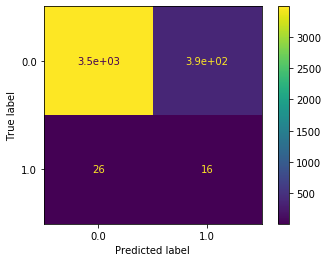

In [48]:
plot_confusion_matrix(mod_opt_RF, X_test.drop(unused_features, axis = 1), y_test)

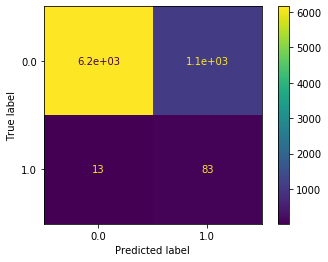

In [49]:
plot_confusion_matrix(mod_opt_RF, X_train.drop(unused_features, axis = 1), y_train)

In [ ]:
importances = mod_opt_RF.feature_importances_
forest_importances = pd.Series(importances, index=X_train.drop(unused_features, axis = 1).columns)
std = np.std([
    tree.feature_importances_ for tree in mod_opt_RF.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


### Feature description

**is_test**:  if is_test = 1 then the row belongs to the test dataset \
**ice_jam_same_day_last_year**: 1 if there were and ice jam on the same day last year \
**ice_jam_same_day_prelast_year**: 1 if there were and ice jam on the same day 2 years ago \
**is_last_year_missing**: 1 is the same day is missing last year \
**is_prelast_year_missing**: 1 is the same day is missing 2 years ago \
**n_jams_last_year**: number of jams last year at the station \
**n_jams_past**: number of jams in the past available data at the station \
**n_same_days_before**: number of same days available in the past \
**n_ice_jams_same_days_before**: number of ice jams ob the same day in the past \
**n_ice_jams_same_days_before_ratio**: n_ice_jams_same_days_before/n_ice_jams_same_days_before

## Retrain the model on all data

In [ ]:
all_train = X[(X['is_test'] == False)].drop('ice_jam', axis = 1).reset_index(drop=True).dropna()
X_val = X[(X['is_test'] == True)].drop('ice_jam', axis = 1).reset_index(drop=True).dropna()
all_y_train =  X.loc[(X['is_test'] == False),'ice_jam']
unused_features = ['year', 'is_test']
mod_opt_RF = mod_opt_RF.fit(all_train.drop(unused_features, axis = 1), all_y_train)


In [ ]:
X_val['ice_jam'] = mod_opt_RF.predict(X_val.drop(unused_features, axis = 1))

In [ ]:
now = datetime.now()
X_val[['year', 'station_id', 'day', 'ice_jam']].\
    to_csv(sumbit_dir + 'submit-rf' + now.strftime("%m-%d-%Y-%H-%M") + '.csv', index=False)

### submit

In [ ]:
X.to_csv(preprocessed_dir + 'X-' + now.strftime("%m-%d-%Y-%H-%M") + '.csv', index=False)

# XGBoost

In [62]:
model = XGBClassifier()
eval_set =[(X_test.drop(unused_features, axis = 1), y_test)]
model.fit(X_train.drop(unused_features, axis = 1), 
                     y_train,  eval_metric="auc",
                     eval_set=eval_set , verbose=False)   

y_pred = model.predict(X_test.drop(unused_features, axis = 1))
y_train_pred = model.predict(X_train.drop(unused_features, axis = 1))

print('F1-train: {}'.format(f1_score(y_train, y_train_pred)))
print('F1-test: {}'.format(f1_score(y_test, y_pred)))

F1-train: 0.9090909090909091
F1-test: 0.0


In [ ]:
model.get_params()

In [64]:
search_grid_RF = {'max_depth': [2, 3, 4, 5, 6],
                  'max_features': [3, 4, 5, 6],
                  'n_estimators': [20, 50, 100, 150],
                  'random_state': [29]
                  }



param_search_xgb = GridSearchCV(estimator=model, 
                               param_grid=search_grid_RF, 
                               scoring=metrics.make_scorer(metrics.f1_score),
                               cv=3, 
                               n_jobs=-1, 
                               verbose=2, return_train_score=True,
                               iid=True)
param_search_xgb.fit(X_train.drop(unused_features, axis = 1), 
                     y_train, early_stopping_rounds=10, 
                     eval_set=[(X_test.drop(unused_features, axis = 1),)] , verbose=True)        

print(param_search_xgb.best_params_)
mod_opt_xgb = XGBClassifier(**param_search_xgb.best_params_)
mod_opt_xgb = mod_opt_xgb.fit(X_train.drop(unused_features, axis = 1), y_train)

y_pred = mod_opt_xgb.predict(X_test.drop(unused_features, axis = 1))
y_train_pred = mod_opt_xgb.predict(X_train.drop(unused_features, axis = 1))

threshold_RF = 0.3
print('F1-train: {}'.format(f1_score(y_train, y_train_pred)))
print('F1-test: {}'.format(f1_score(y_test, y_pred)))

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.2s


[0]	validation_0-error:0.01073
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.01073
[2]	validation_0-error:0.01073
[3]	validation_0-error:0.01073
[4]	validation_0-error:0.01073
[5]	validation_0-error:0.01073
[6]	validation_0-error:0.01073
[7]	validation_0-error:0.01073
[8]	validation_0-error:0.01073
[9]	validation_0-error:0.01073
[10]	validation_0-error:0.01073
Stopping. Best iteration:
[0]	validation_0-error:0.01073



[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   20.8s finished
C:\Users\omore\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'max_depth': 2, 'max_features': 3, 'n_estimators': 20, 'random_state': 29}
F1-train: 0.0
F1-test: 0.0


# I stopped here

### Соберем фичи из гидроданных

<div class="alert alert-block alert-warning">
Мы не можем использовать данные из будущего: всё, что происходит после заторного периода, относится уже к следующему году.
</div>

In [ ]:
# Внесем не темпоральные данные
main_df = pd.merge(main_df, hc[['station_id', 
                                'distance_from_source', 
                                'drainage_area', 
                                'z_null']], on='station_id', how='left')

# Возьмем также данные из ежедневных наблюдений
hld = pd.read_csv(data_dir + 'hydro_1day.csv',
                   parse_dates=['date'])
hld.head(1)

In [ ]:
main_df.head()

In [ ]:
hld['station_id'] = hld.station_id.astype(int)
mld['station_id'] = mld['station_id'].astype(int)

In [ ]:
hld.head()

In [ ]:
mld.head()

In [ ]:
hld = hld.merge(mld, on=['station_id', 'year', 'month', 'day'], how='inner')
hld = hld.fillna(0)
hld.head()

### Скорректируем год, в который доступно наблюдение

In [ ]:
hld.head()

In [ ]:
# Определим для наблюдения год, в который оно доступно

# Маска-окно между заторным периодом и концом года
# true if after jam
# false otherwise
def after_jam_window(row, local=False):
    if local:
        month = row.month_local
        day = row.date_local.day
    else:
        month = row.month
        day = row.date.day
    return (((month == 6) and (day > 3))
            or (month in [7, 8, 9, 10, 11, 12]))

# Год относительно бизнес-логики
def target_year(row, local=False):
    if local:
        year = row.year_local
    else:
        year = row.year
    if after_jam_window(row):
        return year + 1
    else:
        return year
    
hld['target_year'] = hld.apply(target_year, axis=1)

# Календарный год и день больше не нужны
hld.drop(columns=['year', 'date', 'day'], axis=1, inplace=True)

In [ ]:
hld.head()

In [ ]:
# Гидро – сделаем ресэмплинг по месяцу

index = ['station_id', 'month', 'target_year']

hld_mean = hld.groupby(index).mean().add_prefix('mean_').reset_index()
hld_max = hld.groupby(index).max().add_prefix('max_').reset_index()
hld_min = hld.groupby(index).min().add_prefix('min_').reset_index()
hld_std = hld.groupby(index).std().add_prefix('std_').reset_index()
data_frames = [hld_mean, hld_max, hld_min, hld_std]

hydro_monthly = pd.concat(data_frames, axis=1)
hydro_monthly = hydro_monthly.loc[:,~hydro_monthly.columns.duplicated()]
hydro_monthly.sort_values(index).head()

In [ ]:
def make_features(df):
    station, target_year = df.name
    result = pd.DataFrame()
    for month, mdf in df.groupby('month'):
        m_feats = mdf[df.columns[4:]].add_prefix(str(month) + '_').reset_index(drop=True)
        result = pd.concat([result, m_feats], axis=1)
    return result.reset_index(drop=True)
        
hydro_features = hydro_monthly.groupby(['station_id', 'target_year']).apply(make_features)
hydro_features = hydro_features.reset_index(level=2, drop=True).reset_index()
hydro_features.dropna(how='all', axis=1, inplace=True)
hydro_features

### Соберем фичи в основной датасет

<div class="alert alert-block alert-success">
Важно: merge делаем по target_year.
</div>

In [ ]:
main_df = pd.merge(main_df, hydro_features, left_on=['year', 'station_id'],
                   right_on=['target_year', 'station_id'],
                   how='left')
cols = main_df.columns.to_list()
main_df = main_df[cols[:3] + [cols[7]] + cols[5:7] + cols[8:] + [cols[3]]]
main_df.dropna(how='any',inplace=True)
main_df.head(2)

### Нормируем фичи

In [ ]:
from sklearn.preprocessing import StandardScaler

ids, data, target = main_df[main_df.columns[:4]], main_df[main_df.columns[4:-1]], main_df[main_df.columns[-1]]

scaler = StandardScaler()
scaler.fit(data)
transformed_data = scaler.transform(data)
norm_df = pd.concat([ids, pd.DataFrame(transformed_data, columns = main_df.columns[4:-1]), target], axis=1)
norm_df

In [ ]:
# Разделим на трейн и тест исходя из target_year

test = norm_df[~norm_df.target_year.isin(X_train.year.to_list())].reset_index(drop=True).dropna()
train = norm_df[norm_df.target_year.isin(X_train.year.to_list())].reset_index(drop=True).dropna()

# target_year больше не нужна

test.drop(columns=['target_year'], inplace=True)
train.drop(columns=['target_year'], inplace=True)

In [ ]:
# Поделим данные на предикторы и таргет

X_train, y_train = train.iloc[:, :-1], train.ice_jam
X_test, y_test = test.iloc[:, :-1], test.ice_jam

In [ ]:
X_train

### Обучим простой классификатор

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#lsvc = SVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
selector = RFE(LogisticRegression(max_iter=5000),
               n_features_to_select=200, step=10).fit(X_train, y_train)
X_reduced = selector.transform(X_train)
X_reduced_test = selector.transform(X_test)
X_reduced.shape

In [ ]:
pca = PCA()
parameters = {'pca__n_components': list(range(10,50,5)), 'svc__kernel':('linear', 'rbf'), 'svc__C':[1,10]}
clf = Pipeline([('pca', pca), ('svc', SVC(class_weight='balanced'))])
GS = GridSearchCV(clf, parameters, scoring='f1_macro')
GS.fit(X_train, y_train)
print(GS.cv_results_)
print(GS.best_params_)

In [ ]:
prediction = GS.predict(X_test)
recall_score(y_test, prediction), \
    precision_score(y_test, prediction), f1_score(y_test, prediction)

In [ ]:
test = pd.read_csv(data_dir + 'test.csv')
test_real = pd.read_csv(data_dir + '../test_SECRET.csv')

In [ ]:
test_real.head()

In [ ]:
test_X = pd.merge(test_real, hc[['station_id', 
                                'distance_from_source', 
                                'drainage_area', 
                                'z_null']], on='station_id', how='left')

In [ ]:
'year' in hydro_features.columns

In [ ]:
test_X = pd.merge(test_X, hydro_features, left_on=['year', 'station_id'],
                   right_on=['target_year', 'station_id'],
                   how='left')
cols = test_X.columns.to_list()
test_X = test_X[cols[:3] + [cols[7]] + cols[5:7] + cols[8:] + [cols[3]]]

In [ ]:
ids, data, target = test_X[test_X.columns[:4]], test_X[test_X.columns[4:-1]], test_X[test_X.columns[-1]]

transformed_data = scaler.transform(data)
test_X = pd.concat([ids, pd.DataFrame(transformed_data, columns = main_df.columns[4:-1]), target], axis=1)
X_test_real, y_test_real = test_X.iloc[:, :-1], test_X.ice_jam

In [ ]:
X_test_real.drop('target_year',inplace=True,axis=1)
X_test_real = X_test_real.fillna(0)

In [ ]:
#X_test_real_reduced = selector.transform(X_test_real)
prediction =  GS.predict(X_test_real)
accuracy_score(y_test_real, prediction), recall_score(y_test_real, prediction), \
    precision_score(y_test_real, prediction), f1_score(y_test_real, prediction)